In [50]:
import os
import numpy as np
from pydub import AudioSegment
from pydub.playback import play
import IPython 
import torch 

from datasets import load_dataset, Audio
from transformers import EncodecModel, AutoProcessor

import umap
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import plotly.graph_objs as go
from plotly.subplots import make_subplots

def read(f, normalized=False):
    """WAV to numpy array"""
    a = AudioSegment.from_wav(f)
    a = a.set_frame_rate(48000)
    y = np.array(a.get_array_of_samples())
    if a.channels == 2:
        y = y.reshape((-1, 2))
    if normalized:
        return a.frame_rate, np.float32(y) / 2**15
    else:
        return a.frame_rate, y
    
def mix_wav_stems(wav1_path, wav2_path, output_path):
    
    # Load the WAV files
    stem1 = AudioSegment.from_file(wav1_path)
    stem2 = AudioSegment.from_file(wav2_path)

    # Make sure the stems have the same frame rate
    if stem1.frame_rate != stem2.frame_rate:
        raise ValueError("Stems must have the same frame rate")

    # Make sure the stems have the same number of channels
    if stem1.channels != stem2.channels:
        raise ValueError("Stems must have the same number of channels")

    # Mix the stems together
    mixed_stem = stem1.overlay(stem2)
    mixed_stem.export(output_path, format="wav")

def model_results(path):
    sr, song_array = read(path, normalized=False)
    song_name = path.split('\\')[-1]
    
    # pre-process the inputs
    # inputs.input_values.shape = torch.Size([1, 2, 523200]) where 523200/48000 = seconds of loop
    inputs = processor(raw_audio=np.transpose(song_array), sampling_rate=sr, return_tensors="pt")

    # explicitly encode then decode the audio inputs
    encoder_outputs = model.encode(inputs["input_values"], inputs["padding_mask"], return_dict = True)
    audio_values = model.decode(encoder_outputs.audio_codes, encoder_outputs.audio_scales, inputs["padding_mask"])[0]
    return sr, encoder_outputs, audio_values, song_name

def plot_umap(song_list, n):
    fig = make_subplots(rows=1, cols=1, specs=[[{'type': 'scatter3d'}]])

    encoder_outputs_list = [song[1] for song in song_list]
    song_names = [song[3] for song in song_list]

    # Concatenate reshaped data from all examples
    all_audio_data = np.concatenate([enc_outputs.audio_codes.numpy().squeeze() for enc_outputs in encoder_outputs_list])

    # Assuming all examples have the same number of time steps
    reshaped_data = np.reshape(all_audio_data, (all_audio_data.shape[0], -1))

    # Create UMAP reducer and fit on all examples
    reducer = umap.UMAP(n_neighbors=n, random_state=42, n_components=2)
    umap_result = reducer.fit(reshaped_data)

    for i, enc_outputs in enumerate(encoder_outputs_list):
        audio_data = enc_outputs.audio_codes.numpy().squeeze()
        reshaped_data = np.reshape(audio_data, (audio_data.shape[0], -1))

        # Use transform for all encoder outputs
        umap_result_single = umap_result.transform(reshaped_data)

        distance_from_viewer = np.linalg.norm(umap_result_single, axis=1)
        normalized_distances = (distance_from_viewer - min(distance_from_viewer)) / (
                    max(distance_from_viewer) - min(distance_from_viewer))
        marker_sizes = 50 * (1 - normalized_distances)

        scatter_trace = go.Scatter3d(
            x=list(range(audio_data.shape[0])),
            y=umap_result_single[:, 0],
            z=umap_result_single[:, 1],
            mode='markers+lines',
            marker=dict(size=marker_sizes, opacity=0.5),
            line=dict(width=2),
            name=song_names[i],
        )

        fig.add_trace(scatter_trace)

    fig.update_layout(
        scene=dict(
            xaxis=dict(title='Time Step'),
            yaxis=dict(title='UMAP Component 1'),
            zaxis=dict(title='UMAP Component 2'),
        ),
        title='Interactive 3D UMAP Visualization of Audio Data with Time on X-Axis (Size based on Distance)',
        margin=dict(l=0, r=0, b=0, t=40),
    )

    fig.show()

## Without size point adjustment
def plot_umap(song_list, n):
    fig = make_subplots(rows=1, cols=1, specs=[[{'type': 'scatter3d'}]])

    encoder_outputs_list = [song[1] for song in song_list]
    song_names = [song[3] for song in song_list]

    # Concatenate reshaped data from all examples
    all_audio_data = np.concatenate([enc_outputs.audio_codes.numpy().squeeze() for enc_outputs in encoder_outputs_list])

    # Assuming all examples have the same number of time steps
    reshaped_data = np.reshape(all_audio_data, (all_audio_data.shape[0], -1))

    # Create UMAP reducer and fit on all examples
    reducer = umap.UMAP(n_neighbors=n, random_state=42, n_components=2)
    umap_result = reducer.fit(reshaped_data)

    for i, enc_outputs in enumerate(encoder_outputs_list):
        audio_data = enc_outputs.audio_codes.numpy().squeeze()
        reshaped_data = np.reshape(audio_data, (audio_data.shape[0], -1))

        # Use transform for all encoder outputs
        umap_result_single = umap_result.transform(reshaped_data)

        scatter_trace = go.Scatter3d(
            x=list(range(audio_data.shape[0])),
            y=umap_result_single[:, 0],
            z=umap_result_single[:, 1],
            mode='markers+lines',
            marker=dict(size=8, opacity=0.5),  # Adjust the marker size as needed
            line=dict(width=2),
            name=song_names[i],
        )

        fig.add_trace(scatter_trace)

    fig.update_layout(
        scene=dict(
            xaxis=dict(title='Time Step'),
            yaxis=dict(title='UMAP Component 1'),
            zaxis=dict(title='UMAP Component 2'),
        ),
        title='Interactive 3D UMAP Visualization of Audio Data with Time on X-Axis',
        margin=dict(l=0, r=0, b=0, t=40),
        legend=dict(orientation='h', x=0.5, y=-0.15),  # Move legend to the bottom
        height=700,  # Adjust the height of the plot
    )

    fig.show()

def plot_pca(song_list):
    fig = make_subplots(rows=1, cols=1, specs=[[{'type': 'scatter3d'}]])

    encoder_outputs_list = [song[1] for song in song_list]
    song_names = [song[3] for song in song_list]

    # Concatenate reshaped data from all examples
    all_audio_data = np.concatenate([enc_outputs.audio_codes.numpy().squeeze() for enc_outputs in encoder_outputs_list])

    # Assuming all examples have the same number of time steps
    reshaped_data = np.reshape(all_audio_data, (all_audio_data.shape[0], -1))

    # Create PCA reducer and fit on all examples
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(reshaped_data)

    for i, enc_outputs in enumerate(encoder_outputs_list):
        audio_data = enc_outputs.audio_codes.numpy().squeeze()
        reshaped_data = np.reshape(audio_data, (audio_data.shape[0], -1))

        # Use transform for all encoder outputs
        pca_result_single = pca.transform(reshaped_data)

        scatter_trace = go.Scatter3d(
            x=list(range(audio_data.shape[0])),
            y=pca_result_single[:, 0],
            z=pca_result_single[:, 1],
            mode='markers+lines',
            marker=dict(size=8, opacity=0.5),  # Adjust the marker size as needed
            line=dict(width=2),
            name=song_names[i],
        )

        fig.add_trace(scatter_trace)

    fig.update_layout(
        scene=dict(
            xaxis=dict(title='Time Step'),
            yaxis=dict(title='PCA Component 1'),
            zaxis=dict(title='PCA Component 2'),
        ),
        title='Interactive 3D PCA Visualization of Audio Data with Time on X-Axis',
        margin=dict(l=0, r=0, b=0, t=40),
        legend=dict(orientation='h', x=0.5, y=-0.15),  # Move legend to the bottom
        height=700,  # Adjust the height of the plot
    )

    fig.show()

In [15]:
path = 'D:\\Phd\\Phd Dummy audio'

folders = os.listdir(path)
output_paths = []

for i, folder in enumerate(folders):
    folder_path = os.path.join(path, folder)
    files = [file for file in os.listdir(folder_path) if file != 'output']
    files.sort() 
    
    for j, file1 in enumerate(files):
        for k, file2 in enumerate(files):
            if (file1  != 'output') and (file2 != 'output'):
                if j < k:  # Ensure lexicographical order
                    wav1_path = os.path.join(folder_path, file1)
                    wav2_path = os.path.join(folder_path, file2)

                    output_folder = os.path.join(folder_path, 'output')
                    os.makedirs(output_folder, exist_ok=True)

                    output_name = f"output_{file1.split('-')[-1].replace('.wav', '').strip()}_{file2.split('-')[-1].replace('.wav', '').strip()}.wav"
                    output_path = os.path.join(output_folder, output_name)
                    output_paths.append(output_path)

                    # Check if the output file already exists
                    if not os.path.exists(output_path):
                        mix_wav_stems(wav1_path, wav2_path, output_path)
                        
# load the model + processor (for pre-processing the audio)
model = EncodecModel.from_pretrained("facebook/encodec_48khz")
processor = AutoProcessor.from_pretrained("facebook/encodec_48khz")

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


In [16]:
import pandas as pd

pd.DataFrame(output_paths).to_csv('output_paths.csv')

In [7]:
# Display the audio file
IPython.display.Audio(output_paths[10])

In [8]:
IPython.display.Audio(output_paths[13])

In [48]:
base_other = model_results('\\'.join(output_paths[1].split('\\')[:-2] + ['boi - Bass.wav']))
base = model_results('\\'.join(output_paths[10].split('\\')[:-2] + ['c harm minor dummy - Bass.wav']))
song1 = model_results(output_paths[10])
song2 = model_results(output_paths[11])
song3 = model_results(output_paths[12])
song4 = model_results(output_paths[13])

In [9]:
# Decoder output
#audio_values_np = song2[2][0,0,:].detach().numpy()
#IPython.display.Audio(audio_values_np, rate=48000)

In [17]:
song1[1].audio_codes.numpy().squeeze().shape

(9, 2, 150)

C:\Users\konin\anaconda3\Lib\site-packages\umap\umap_.py:1943: UserWarning:

n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.



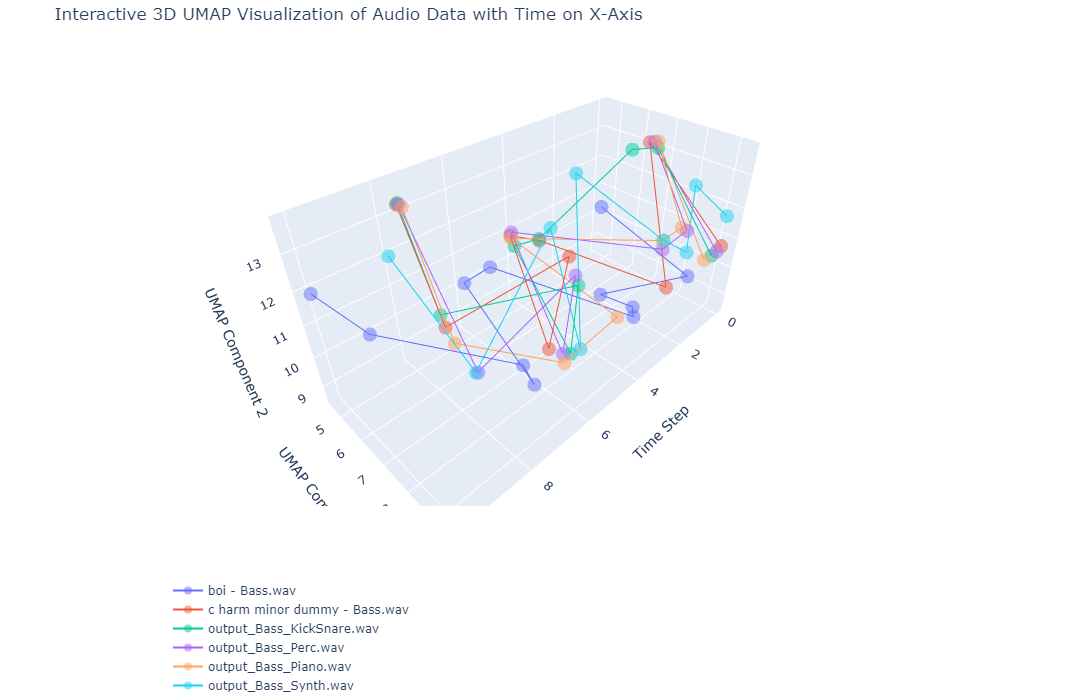

In [49]:
song_list = [base_other, base, song1, song2, song3, song4]

plot_umap(song_list,song1[1].audio_codes.shape[0]*len(song_list)-1)

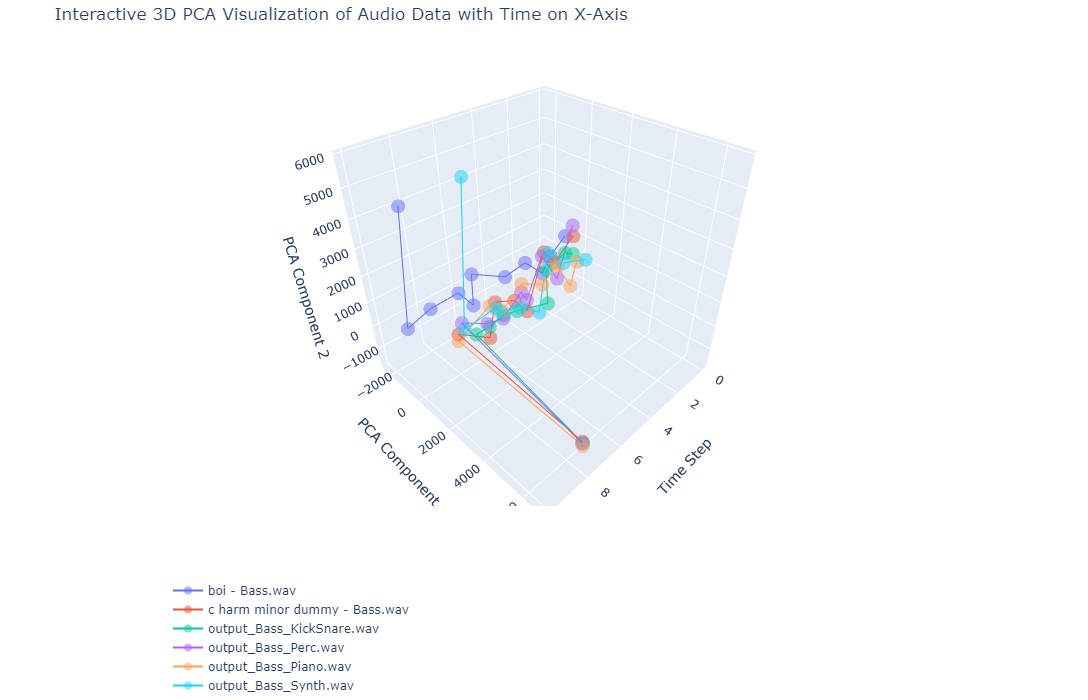

In [52]:
plot_pca(song_list)